# Chapter 2 – End-to-end Machine Learning project

# Vorbereitung


#### Dieses Noteboook wurde erstellt von Aurelien Geron. Es gehört zu dessen Buch "Hands-on Machine Learning with Scikit-learn,Keras and Tensorflow ". 
<p>Das Original-Notebook kann man finden unter https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
<p>   Das Notebook wurde für Unterrichtszwecke verändert und kommentiert von Elisabeth Staegemann

In [1]:
#Angeben, unter welchen Systemvoraussetzungen das Notebook läuft

import sys
assert sys.version_info >= (3, 7)


import sklearn #"scikit-learn"
assert sklearn.__version__ >= "1.2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#### Schreibe eine Funktion für den einfachen Download

In [2]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data(url,ordner_name,csv_name):
    ordner = Path(ordner_name)
    tarball_path = ordner / Path(url).name # der  Filename des Archivs
    #csv_file = ordner / Path(csv_name)    
   
    if not tarball_path.is_file():
        ordner.mkdir(parents=True, exist_ok=True)        
        urllib.request.urlretrieve(url, tarball_path)
        
    csv_file = ordner / "housing" / csv_name
    # der tarball erzeugt beim Auspacken den Ordnernamen "housing"
    # das muss man wissen
        
    if not csv_file.is_file():
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=ordner.name)           
            
    return pd.read_csv(csv_file)
    
    

*Welcome to Machine Learning Housing Corp.! _____________________Your task is to predict median house values in Californian districts, given a number of features from these districts.*

## Daten laden

In [3]:
housing_gesamt \
= load_housing_data(url="https://github.com/ageron/data/raw/main/housing.tgz", 
                    ordner_name="datasets", csv_name="housing.csv")
#print(type(housing_gesamt))

C:\Users\felip\AppData\Local\Temp\ipykernel_48444\419511465.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path=ordner.name)


# Eine Testmenge erstellen

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

Sadly, this won't guarantee that this notebook will output exactly the same results as in the book, since there are other possible sources of variation. The most important is the fact that algorithms get tweaked over time when libraries evolve. So please tolerate some minor differences: hopefully, most of the outputs should be the same, or at least in the right ballpark.

In [4]:
# Daten in Trainingsmenge und Testmenge aufteilen
# Testmenge soll repräsentativ sein 
#                          (Verallgemeinerung des Modells muss möglich sein)
#Frage: Wie groß soll die Testmenge sein?

#### Variante 1: Trennungsfunktion selbst schreiben

In [5]:
# Code-Erklärung 1
# Das Ausgeben von Spalten, Zeilen und Zellen bei einem Pandas-Dataframe

In [4]:
import numpy as np
np.random.seed(42)

In [5]:
import numpy as np

def shuffle_and_split_data(data, test_ratio): 
   
    shuffled_indices = np.random.permutation(len(data))#20_000
    test_set_size = int(len(data) * test_ratio)#4_000
    test_indices = shuffled_indices[:test_set_size]#[0:4_000],1,3,8...
    train_indices = shuffled_indices[test_set_size:   ]#2,4,5,6,7,9...
    return (data.iloc[train_indices], data.iloc[test_indices])



In [6]:
trainingsset, testset = shuffle_and_split_data(housing_gesamt, 0.2)

In [7]:
trainingsset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-122.37,37.94,49.0,969.0,229.0,599.0,195.0,1.3167,71600.0,NEAR BAY
11964,-118.38,33.89,35.0,1778.0,330.0,732.0,312.0,6.5745,379300.0,<1H OCEAN
5390,-119.33,36.28,16.0,2624.0,527.0,1077.0,520.0,2.1250,104200.0,INLAND
860,-117.19,34.08,22.0,2467.0,555.0,1567.0,494.0,2.6536,84700.0,INLAND


In [8]:
testset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,-121.92,40.52,13.0,4581.0,881.0,1799.0,734.0,2.2993,99500.0,INLAND
16623,-122.08,37.68,26.0,2607.0,682.0,1401.0,607.0,2.6563,184100.0,NEAR BAY
18086,-119.00,35.39,42.0,2839.0,516.0,1203.0,487.0,3.7708,79400.0,INLAND
2144,-117.92,33.63,39.0,1469.0,226.0,553.0,225.0,7.8496,490800.0,<1H OCEAN


In [9]:
#Überprüfen, ob die Länge richtig ist
print("alle Datensätze:",len(housing_gesamt))
print("Testset:",len(testset) )
# alles so groß, wie erwartet

alle Datensätze: 20640
Testset: 4128


#### Variante 2:Trennungsfunktion selbst schreiben, dabei Orientierung an einer ID-Spalte


In [10]:
# z.B. ID-Spalte=Datumsangabe, Trennung in frühere und spätere Daten
# z.B. ID-Spalte =Kombination aus Längengrad und Breitengrad, 
#                 Training mit den nördlichen Häusern, Test mit den südlichen Häusern

#### Variante 3: die vordefinierte Funktion aus scikit-learn benutzen

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_gesamt, test_size=0.2, random_state=42)
train_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND
17848,-122.49,37.79,52.0,2488.0,281.0,805.0,295.0,10.7058,500001.0,NEAR BAY
6252,-123.38,41.80,25.0,1941.0,477.0,1000.0,390.0,2.2976,54400.0,INLAND
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,145800.0,<1H OCEAN
6113,-119.95,38.94,24.0,2180.0,517.0,755.0,223.0,2.5875,173400.0,INLAND
6061,-122.66,38.47,23.0,2246.0,437.0,1035.0,386.0,3.7617,172600.0,<1H OCEAN


In [12]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


In [ ]:
#df = test_set[test_set["income_cat"]=="hoch"].copy()

#### Variante 4: Stratifizierte Trennung von Test und Trainingsmenge

<Axes: >

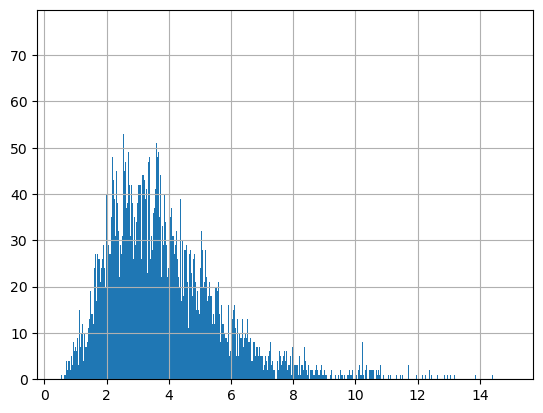

In [19]:
# Bevor stratifiziert wird, 
# muss man kontinuierliche Daten in Kategorien umwandeln.
# Reicht es aus , die Kategorien eines normalen Histogramms zu wählen?
# Bei diesem Beispiel sicher nicht.0
housing_gesamt["median_income"].hist(bins=2000)
#Versuche mit bins =200, =2000

In [16]:
# Wir legen die Kategorien mit Hilfe der pandas-Funktion cut fest.
# Die Grenzen bestimmen wir selbst
housing_gesamt["income_cat"] = pd.cut(housing_gesamt["median_income"],
                               bins=[0., 1, 2.,4.,6.,np.inf],
                               labels=["arm", "gering", "mittel", "hoch", "reich"])

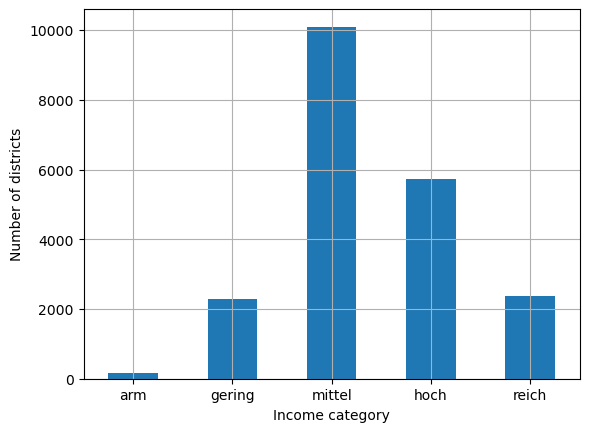

In [17]:
# Wir zeichnen, wieviele Elemente zu jeder Kategorie gehören.
housing_gesamt["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

plt.xlabel("Income category")
plt.ylabel("Number of districts")

plt.show()

#### Variante 4a: mehrere stratifizierte Splits auf einmal erzeugen: "doppelt hält besser"

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_gesamt, housing_gesamt["income_cat"]):
    strat_train_set_n = housing_gesamt.loc[train_index]
    strat_test_set_n = housing_gesamt.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [21]:
strat_train_set, strat_test_set = strat_splits[0]

#### Variante 4b: ein einfacher stratifizierter split kann auch mit train_test_split erreicht werden

In [22]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(
    housing_gesamt, test_size=0.2, 
    stratify=housing_gesamt["income_cat"], 
    random_state=42)
"""
train_test_split(Datensatz, Zielspalte, stratify=Zielspalte)
train_test_split(X, y, stratify=y) 
# von jeder Kategorie der Zielspalte ist der richtige Prozentsatz enthalten
train_test_split(X, y, stratify=X.iloc[:,0])
# von der ersten Datenspalte ist der richtige Prozentsatz enthalten
# weil die erste Spalte wichtig ist für die Voraussage
"""
print()

#### Den Effekt der Stratifizierung überprüfen

In [23]:
strat_test_set["income_cat"].value_counts()    / len(strat_test_set)

income_cat
mittel    0.489099
hoch      0.277374
reich     0.114341
gering    0.111434
arm       0.007752
Name: count, dtype: float64

In [24]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_gesamt, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing_gesamt),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / 
                                   compare_props["Overall %"] 
                                   - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
#(compare_props * 100).round(2)
compare_props*100
#(4-3.98)/3.98------------------------4/3.98 - 3.98/3.98

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
arm,0.770349,0.775194,0.750969,0.628931,-2.515723
gering,11.133721,11.143411,11.385659,0.087032,2.262837
mittel,48.914729,48.909884,47.238372,-0.009905,-3.427100
hoch,27.737403,27.737403,28.536822,0.000000,2.882096
reich,11.443798,11.434109,12.088178,-0.084674,5.630821


In [25]:
for set1 in (strat_train_set, strat_test_set):
    set1.drop("income_cat", axis=1, inplace=True)
    

## Zielspalte abtrennen

In [26]:
# Wir trennen die Zielspalte (=Target = Label) von den restlichen Daten, da wir die Zielspalte voraussagen wollen.
housing_train_data = strat_train_set.drop("median_house_value", axis=1)
housing_train_labels = strat_train_set["median_house_value"].copy()
housing_test_data = strat_train_set.drop("median_house_value", axis=1)
housing_test_labels = strat_train_set["median_house_value"].copy()


In [27]:
# Wir prüfen noch einmal, ob die Trainingsdaten die richtige Größe haben
print("Größe der Trainingsdaten", housing_train_data.shape)
print("Größe der Trainingslabels", housing_train_labels.shape)

Größe der Trainingsdaten (16512, 9)
Größe der Trainingslabels (16512,)


## Abspeichern der vorbereiteten Daten

In [28]:
# Abspeichern der vorbereiteten Trainingsdaten

#Dateiname sollte housing_train_prepared.pickle heißen
# vor dem Einpacken der Testmenge darf die preparation kein fit machen !!!

import pickle
with open('datasets/housing_train_raw.pickle', 'wb') as f:
    # Einpacken von allen vorbereiteten Trainingsdaten
    pickle.dump(housing_train_data, f, pickle.HIGHEST_PROTOCOL)
    
with open('datasets/housing_train_labels.pickle', 'wb') as f:
    #Einpacken der Trainingslabel
    pickle.dump(housing_train_labels, f, pickle.HIGHEST_PROTOCOL)
    
    
# Abspeichern der vorbereiteten Testdaten
    

housing_test_labels =strat_test_set["median_house_value"]
    
with open('datasets/housing_test_raw.pickle', 'wb') as f:
    # Einpacken von allen unvorbereiteten Testdaten
    pickle.dump(housing_test_data, f, pickle.HIGHEST_PROTOCOL)   
with open('datasets/housing_test_labels.pickle', 'wb') as f:
    # Einpacken von allen unvorbereiteten Testdaten
    pickle.dump(housing_test_labels, f, pickle.HIGHEST_PROTOCOL)  

    